In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
from tensorflow.keras.utils import load_img
import keras.utils as image
import cv2

import warnings
warnings.filterwarnings('ignore')

# Importing Dataset

In [4]:
directory_train = '/kaggle/input/covid19-chest-xray-dataset-augmented-80/Dataset/train'
directory_validation = '/kaggle/input/covid19-chest-xray-dataset-augmented-80/Dataset/val'
directory_test = '/kaggle/input/covid19-chest-xray-dataset-augmented-80/Dataset/est'

# Augmentation

In [5]:
gen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

In [6]:
train_generator = gen.flow_from_directory(
    directory = directory_train,
    color_mode="rgb",
    target_size = (224,224), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 21839 images belonging to 2 classes.


In [7]:
validation_generator = gen.flow_from_directory(
    directory = directory_validation, 
    color_mode="rgb",
    target_size = (224,224), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 455 images belonging to 2 classes.


In [8]:
x,y = next(train_generator)
x.shape

(8, 224, 224, 3)

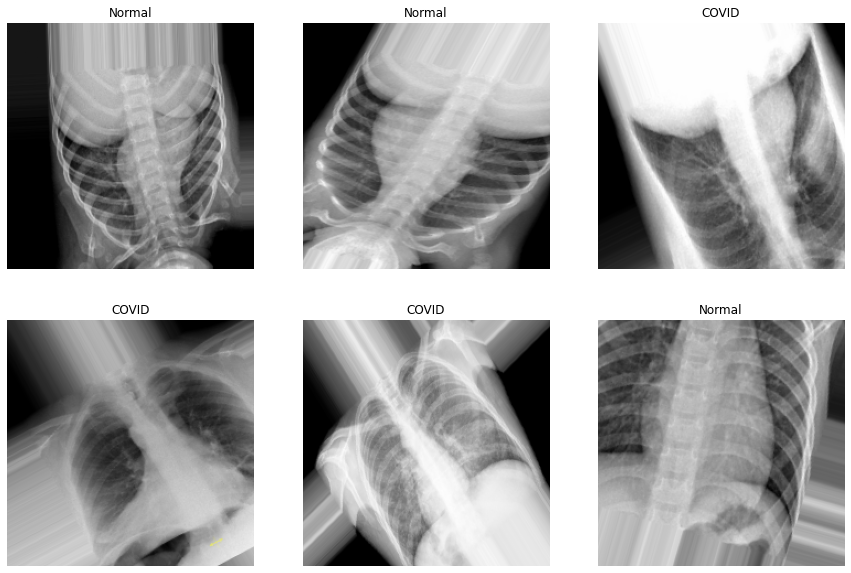

In [9]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

plot_images(x,y)

# Model Creation
> Version-VGG16

In [10]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

base_model.trainable=False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax')
])

2023-01-10 23:36:03.047793: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


58900480/58889256 [==============================] - 2s 0us/step


In [11]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 512)         3584      
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3

In [13]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                         min_delta=0.001,
                                         restore_best_weights=True)

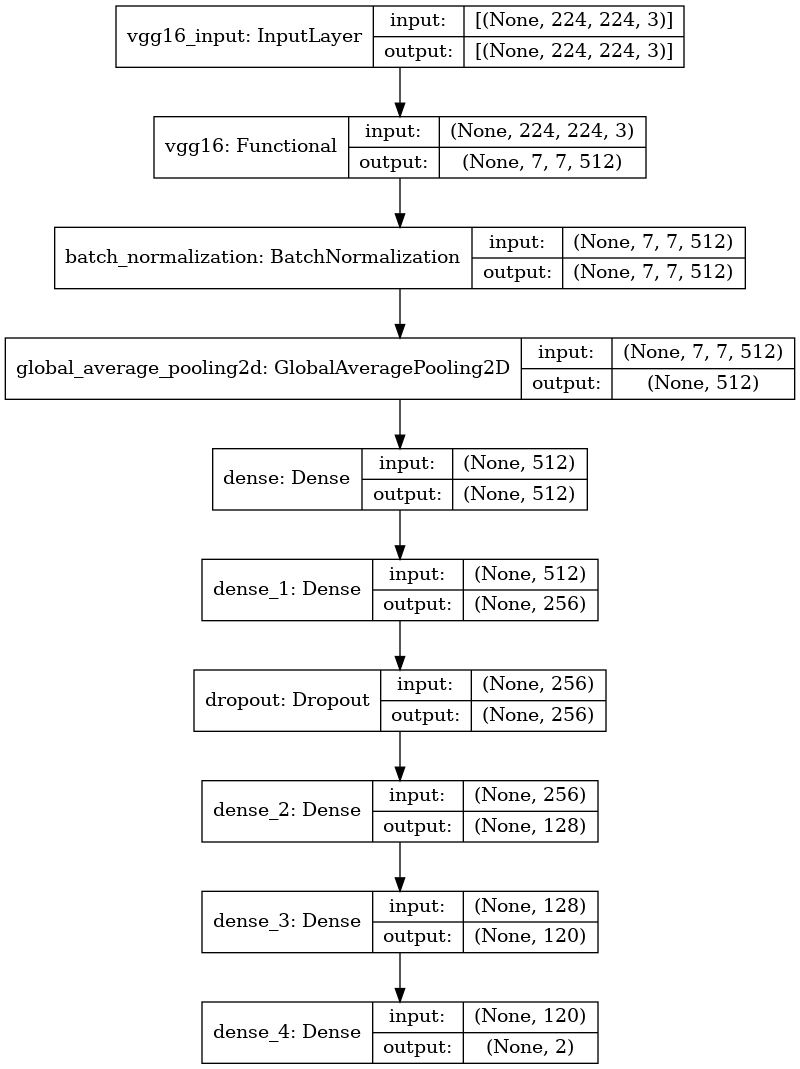

In [14]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
batch_size=800
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2,
                    callbacks=[early]
)

2023-01-10 23:36:07.302397: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
1381/2729 [==============>...............] - ETA: 40:30 - loss: 0.3713 - categorical_accuracy: 0.8901

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5,1.05])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {(str(acc[-1]))} \nValidation Accuracy: {str(val_acc[-1])}')

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

In [ ]:
images = []
for img in os.listdir(directory_test):
    img = os.path.join(directory_test, img)
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    images.append(img)

In [ ]:
images = np.vstack(images)
classes = model.predict(images)
print(classes)

In [ ]:
Y_pred = model.predict_generator(validation_generator, 60 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Covid', 'Normal']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))